# Data Processing

In [1]:
#!pip install Keras gensim pandas numpy nltk python-decouple scikit-learn scipy matplotlib pymorphy2
#!pip install -U pymorphy2-dicts-uk # dictionary for the Ukrainian language

## DOWNLOAD

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Importing the dataset
#df = pd.read_csv('Covid-data-2020.csv', sep=',')
txt = pd.read_csv('wiki_dump.lemmatized.txt', sep=';', header = None)
txt.columns = ["text"]

In [4]:
txt.dropna(inplace=True)

In [5]:
#words_list = txt.values.tolist()

# CORPUS

## NLTK (Natural Language Toolkit)

NLTK is a leading platform for building Python programs to work with human language data.

It provides easy-to-use interfaces and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

Note:

    word_tokenize - extract words from the text;
    sent_tokenize - extract sentences from the text.



In [6]:
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer

def word_sent_tokenize(sent):
    return word_tokenize(sent), sent_tokenize(sent)

def regex_tokenizer(sent):
    return RegexpTokenizer(r'\w+').tokenize(sent)

words, sents = word_sent_tokenize(txt.text[0])
print("\tTest-Words:\n", words, "\n\n\tTest-Sentences:\n", sents)

	Test-Words:
 ['географія'] 

	Test-Sentences:
 ['географія']


## StopWords

In [7]:
from stop_words import get_stop_words
from nltk.corpus import stopwords

STOP_WORDS = list(get_stop_words('ukrainian'))

stopwords_ua = pd.read_csv('stopwords_ua.txt', header=None, names=['stopwords']).values
stopwords_ua = [i[0] for i in stopwords_ua]

stopwords_ua_73 = pd.read_csv('stopwords_ua-73.txt', header=None, names=['stopwords']).values
stopwords_ua_73 = [i[0] for i in stopwords_ua_73]

stopwords_ua_1983 = pd.read_csv('stopwords_ua-1983.txt', header=None, names=['stopwords']).values
stopwords_ua_1983 = [i[0] for i in stopwords_ua_1983]

#stopwords_Lu = pd.read_csv('stopwords_Lutsenko.txt', header=None, names=['stopwords']).values
#stopwords_Lu = [i[0] for i in stopwords_Lu]

STOP_WORDS.extend(stopwords_ua)
STOP_WORDS.extend(stopwords_ua_73)
STOP_WORDS.extend(stopwords_ua_1983)
#STOP_WORDS.extend(stopwords_Lu)

print('We used', len(set(STOP_WORDS)), 'stop words')
STOP_WORDS = list(set(STOP_WORDS))

We used 1989 stop words


In [8]:
def stopwords_elimination(stop_words, sent):
    return [w for w in sent if w not in stop_words]

filtered_words = stopwords_elimination(STOP_WORDS, words)
print("\n\n==================== WORDS from Test-Words ====================\n", words,
      "\n\n================== FILTERED from Test-Words ==================\n", filtered_words)



==================== WORDS from Test-Words ====================
 ['географія'] 

================== FILTERED from Test-Words ==================
 ['географія']


In [9]:
#!pip install opencv-python wordcloud

## Lemmatizing

<cite><b>Lemmatization</b>, unlike <b>Stemming</b>, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called <b>Lemma</b>. A lemma is the canonical form, dictionary form, or citation form of a set of words.</cite>

At lematization the word loses inflectional endings and finds the basic form. For example, the noun `[плечима — плече]`, the verb `[ходили — ходити]`, the adjective `[смішним — смішний]`.

Python `NLTK` provides `WordNet Lemmatizer` that uses the `WordNet Database` to lookup lemmas of words. But there is no Ukrainian, after some searching I found that in `pymorphy2` there is support for Ukrainian, actually, at the experimental level (at the time of writing - March 2021), but there is.

To install the library, type in the terminal: `pip install pymorphy2` and  `pip install -U pymorphy2-dicts-uk`

Let's connect the library and see how it works:

In [10]:
#!pip install pymorphy2
#!pip install -U pymorphy2-dicts-uk

In [11]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer(lang='uk')
morph.parse('відчувається')

[Parse(word='відчувається', tag=OpencorporaTag('VERB,Refl,impf sing,3per,pres'), normal_form='відчуватися', score=1.0, methods_stack=((DictionaryAnalyzer(), 'відчувається', 281, 12),))]

Now let's try the lematizer on our test:

In [12]:
def lemmatize_words(morph, words):
    return [morph.parse(word)[0].normal_form for word in words]

lemmatized_words = lemmatize_words(morph, filtered_words)
print(lemmatized_words)

['географія']


## Processing the data

Now let's start processing all data using the methods described above. Lematization is quite a time-consuming procedure, so one has to wait:

In [13]:
# Use regex_tokenizer to get rid of punctuation
words_list = [regex_tokenizer(item) for item in list(txt['text'])]
print("Post without punctuation: ", words_list[1])

# Eliminate stopwords
words_list = [stopwords_elimination(STOP_WORDS, word) for word in words_list]
print("\n\nPosts after stopwords elimination: ", words_list[1])

# Lemmatizing
words_list = [lemmatize_words(morph, word) for word in words_list]
print("\n\nPosts after lemmatizing: ", words_list[1])

Post without punctuation:  ['фізичний', 'карта', 'світ']


Posts after stopwords elimination:  ['фізичний', 'карта', 'світ']


Posts after lemmatizing:  ['фізичний', 'карта', 'світ']


## Irrelevent Words Elimination

We will delete all words with Latin letters, words with a length of less than 3 and numbers. I don't know why, but for one cycle, it doesn't delete all superfluous words therefore it was necessary to put for this purpose a `while` cycle.

In [14]:
from re import match 

stop_list = ['україна','коронавірус','карантин','зеленський']

def irr_words_elim(words):
    while True:
        ready = True
        
        for word in words:
            if bool(match(r"[a-zA-Z]", word)) or word.isdigit() or len(word) <= 3 or word in stop_list:
                ready = False
                words.remove(word)
        
        if ready: break
        
    return words

Now actually delete all irrelevant words:

In [15]:
for i in words_list: 
    irr_words_elim(i)

## Vocabulary

In [16]:
# was 1811548
# len(words_list[0])
wl = []
[wl.append(line) for line in words_list if len(line) > 100]
print(len(wl), wl[0])
len(wl[0:-1])

words_list = wl

6782 ['народитися', 'дивитися', 'категорія', 'народитися', 'січень', 'серджио', 'леон', 'італійський', 'сценарист', 'кінорежисер', 'січень', 'микола', 'павлович', 'мащенко', 'український', 'актор', 'сценарист', 'кінорежисер', 'січень', 'мартін', 'лютер', 'кінг', 'американський', 'баптистський', 'священик', 'діяч', 'негритянський', 'рівноправити', 'січень', 'молостовий', 'режисер', 'січень', 'рудольф', 'людвіг', 'мессбауер', 'фізик', 'лютий', 'нінель', 'кургапкін', 'радянський', 'балерина', 'народний', 'артистка', 'срср', 'лютий', 'грем', 'хілл', 'англійський', 'автогонщик', 'лютий', 'брижа', 'теодозій', 'марківна', 'скульптор', 'лютий', 'коркушко', 'олег', 'васильович', 'лютий', 'алексій', 'патріарх', 'московський', 'березень', 'фазіль', 'іскандер', 'російський', 'письменник', 'березень', 'ернст', 'оцвірк', 'австрійський', 'футболіст', 'березень', 'олег', 'стриженов', 'російський', 'кіноактор', 'березень', 'федір', 'михайлович', 'муравченко', 'головний', 'конструктор', 'керівник', 'зап

In [17]:
from nltk import FreqDist
all_words = np.concatenate(wl)
all_words_freq = FreqDist(all_words)

print("Most popular words: ", all_words_freq.most_common(50))
print("\nTotal number of unique words: ", len(all_words_freq.keys()))

Most popular words:  [('район', 9160), ('область', 8497), ('категорія', 6764), ('село', 3519), ('український', 3304), ('державний', 3247), ('олександр', 2914), ('іван', 2646), ('мова', 2553), ('національний', 2512), ('володимир', 2428), ('наука', 2357), ('особа', 2335), ('микола', 2327), ('російський', 2134), ('сільський', 2047), ('файл', 1987), ('вулиця', 1894), ('голова', 1869), ('місто', 1854), ('іванович', 1852), ('центр', 1849), ('великий', 1836), ('університет', 1830), ('міжнародний', 1824), ('премія', 1810), ('міністр', 1800), ('місце', 1791), ('михайло', 1737), ('василь', 1600), ('сергій', 1587), ('найкращий', 1587), ('фільм', 1565), ('робот', 1519), ('право', 1511), ('народний', 1508), ('музей', 1472), ('організація', 1462), ('орден', 1443), ('інститут', 1437), ('член', 1415), ('група', 1402), ('система', 1394), ('юрій', 1372), ('частина', 1341), ('петро', 1331), ('республіка', 1308), ('управління', 1305), ('футболіст', 1296), ('діяльність', 1286)]

Total number of unique word

### Visualization of the most used words after processing

In [24]:
#!pip install opencv-python wordcloud

In [25]:
import cv2
import matplotlib.pyplot as plt
from urllib.request import urlopen
from wordcloud import WordCloud, ImageColorGenerator

In [26]:
def load_mask(mask_url):
    with urlopen(mask_url) as response:
        mask = np.asarray(bytearray(response.read()), dtype="uint8")
        mask = cv2.imdecode(mask, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
    return mask

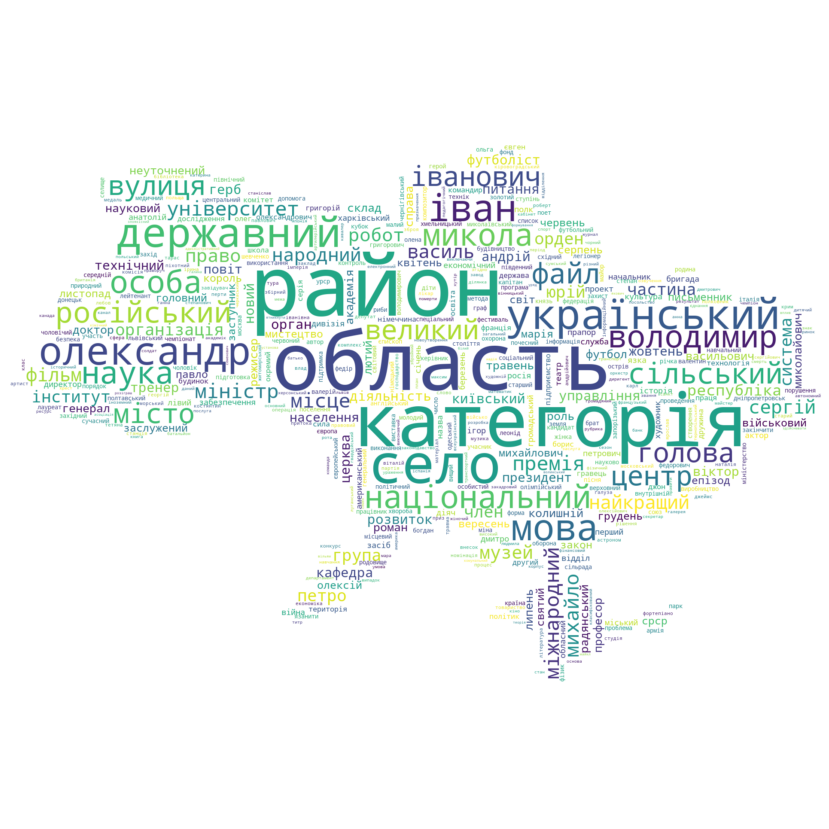

<Figure size 432x288 with 0 Axes>

In [27]:
mask = load_mask("https://i.imgur.com/UVe6Nas.png")

wordcloud = WordCloud(
    background_color="white", 
    mask=mask,
    max_words=500,
    random_state=42,
)

wordcloud.generate_from_frequencies(all_words_freq)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("wordcloud21-sql.png")
plt.savefig("wordcloud-21"+".png", bbox_inches='tight')

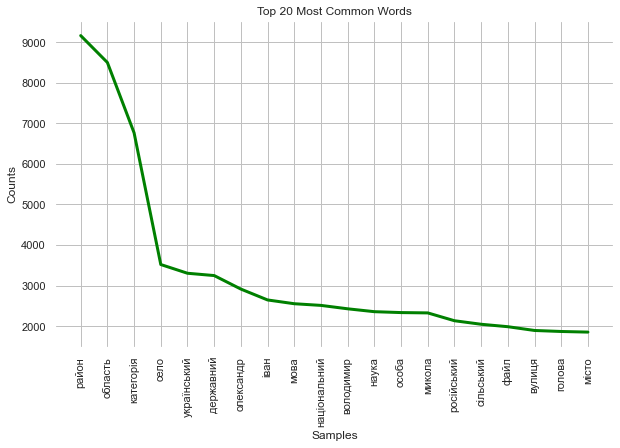

<AxesSubplot:title={'center':'Top 20 Most Common Words'}, xlabel='Samples', ylabel='Counts'>

In [28]:
import seaborn as sns

%matplotlib inline
sns.set()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('xkcd:white')

all_words_freq.plot(20, color="green", title="Top 20 Most Common Words", linewidth=3)

# Pickle

In [ ]:
wl = wl[0:-1]
corpus = [' '.join(post) for post in wl]

In [ ]:
import pickle

obj = {'corpus': corpus, 'words_list': wl, 'all_words': all_words}
output = open('my_corpus.pql', 'wb')
pickle.dump(obj, output, 2)
output.close()